<a href="https://colab.research.google.com/github/oneoftwo/generative_model_tutorials/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoder**

## **Import and Download Dataset**

In [14]:
import numpy as np
import random as random
import time as time
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim

from matplotlib import pyplot as plt
from matplotlib import cm

In [15]:
################################################################################
# excecute ##############################################################
batch_size = 32
download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, transform=transforms.ToTensor(), \
    train=True, download=True)
test_dataset = MNIST(download_root, transform=transforms.ToTensor(), \
    train=False, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, \
    shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, \
    shuffle=True)

## **Model**
Autoencoder model using CNN layers as encoder and inverse CNN layers for decoder

In [19]:
################################################################################
# autoencoder ##################################################################


# encoder for autoencoder, CNN based
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(\
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1), \
            nn.ReLU(), \
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), \
            nn.ReLU(), \
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0), \
            nn.ReLU(), \
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), \
            nn.ReLU(), \
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0))
        self.fc = nn.Sequential(\
            nn.Linear(6 * 6 * 128, 100), \
            nn.ReLU(), \
            nn.Linear(100, 2))

    def forward(self, x):
        b = x.size(0)
        x = self.conv_layers(x)
        x = x.view(b, -1)
        x = self.fc(x)
        return x


# decoder for autoencoder
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(\
            nn.Linear(2, 100), \
            nn.ReLU(), \
            nn.Linear(100, 128 * 6 * 6))
        self.conv_layers = nn.Sequential(\
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0), \
            nn.ReLU(), \
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1), \
            nn.ReLU(), \
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0), \
            nn.ReLU(), \
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1), \
            nn.ReLU(), \
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1, padding=0))
        
    def forward(self, x):
        b = x.size(0)
        x = self.fc(x)
        x = x.view(b, 128, 6, 6)
        x = self.conv_layers(x)
        return x


# autoencoder
class Autoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_regen = self.decoder(z)
        x_regen = torch.sigmoid(x_regen)
        return x_regen, z
    

################################################################################


################################################################################
# sanity check #################################################################
x = torch.rand(128, 1, 28, 28)
auto = Autoencoder()
x_regen ,z = auto(x)
print('size of encoded latent: ', z.size())
print('size of regenerated image: ', x_regen.size())
################################################################################

size of encoded latent:  torch.Size([128, 2])
size of regenerated image:  torch.Size([128, 1, 28, 28])


## **Train**

100%|██████████| 1875/1875 [00:26<00:00, 71.04it/s]


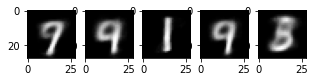

epoch 1 reconstruction loss: 102.292


100%|██████████| 1875/1875 [00:26<00:00, 71.13it/s]


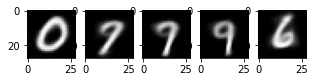

epoch 2 reconstruction loss: 81.558


100%|██████████| 1875/1875 [00:26<00:00, 71.11it/s]


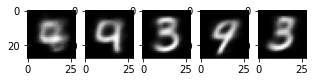

epoch 3 reconstruction loss: 76.495


100%|██████████| 1875/1875 [00:26<00:00, 71.09it/s]


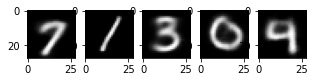

epoch 4 reconstruction loss: 74.000


100%|██████████| 1875/1875 [00:26<00:00, 71.30it/s]


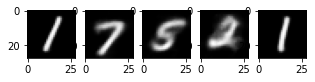

epoch 5 reconstruction loss: 72.336


100%|██████████| 1875/1875 [00:26<00:00, 70.95it/s]


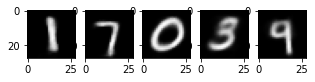

epoch 6 reconstruction loss: 71.108


100%|██████████| 1875/1875 [00:26<00:00, 70.91it/s]


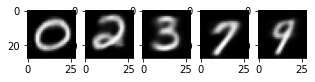

epoch 7 reconstruction loss: 70.287


100%|██████████| 1875/1875 [00:26<00:00, 71.02it/s]


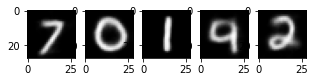

epoch 8 reconstruction loss: 69.530


100%|██████████| 1875/1875 [00:26<00:00, 70.89it/s]


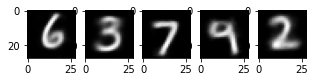

epoch 9 reconstruction loss: 68.940


100%|██████████| 1875/1875 [00:26<00:00, 70.74it/s]


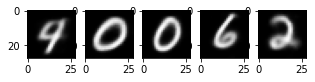

epoch 10 reconstruction loss: 68.408


100%|██████████| 1875/1875 [00:26<00:00, 71.00it/s]


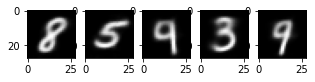

epoch 11 reconstruction loss: 68.003


100%|██████████| 1875/1875 [00:26<00:00, 70.88it/s]


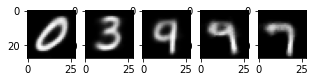

epoch 12 reconstruction loss: 67.648


100%|██████████| 1875/1875 [00:26<00:00, 70.95it/s]


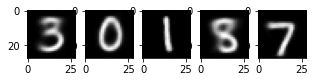

epoch 13 reconstruction loss: 67.267


100%|██████████| 1875/1875 [00:26<00:00, 70.88it/s]


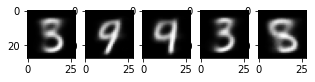

epoch 14 reconstruction loss: 66.940


100%|██████████| 1875/1875 [00:26<00:00, 71.00it/s]


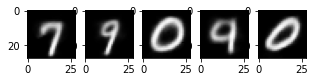

epoch 15 reconstruction loss: 66.685


100%|██████████| 1875/1875 [00:26<00:00, 70.66it/s]


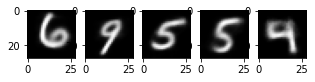

epoch 16 reconstruction loss: 66.426


100%|██████████| 1875/1875 [00:26<00:00, 70.89it/s]


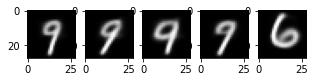

epoch 17 reconstruction loss: 66.222


100%|██████████| 1875/1875 [00:26<00:00, 70.69it/s]


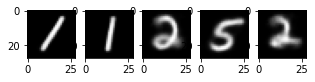

epoch 18 reconstruction loss: 66.018


100%|██████████| 1875/1875 [00:26<00:00, 70.83it/s]


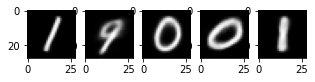

epoch 19 reconstruction loss: 65.798


100%|██████████| 1875/1875 [00:26<00:00, 70.82it/s]


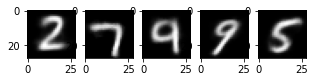

epoch 20 reconstruction loss: 65.551


100%|██████████| 1875/1875 [00:26<00:00, 70.77it/s]


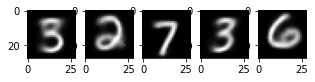

epoch 21 reconstruction loss: 65.408


100%|██████████| 1875/1875 [00:26<00:00, 70.71it/s]


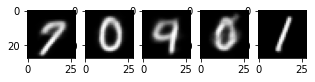

epoch 22 reconstruction loss: 65.228


100%|██████████| 1875/1875 [00:26<00:00, 70.69it/s]


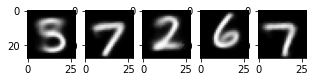

epoch 23 reconstruction loss: 65.075


100%|██████████| 1875/1875 [00:26<00:00, 70.73it/s]


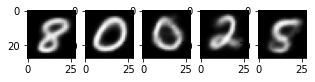

epoch 24 reconstruction loss: 64.823


100%|██████████| 1875/1875 [00:26<00:00, 70.65it/s]


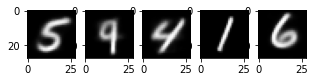

epoch 25 reconstruction loss: 64.743


100%|██████████| 1875/1875 [00:26<00:00, 70.88it/s]


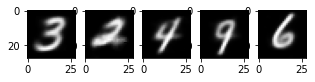

epoch 26 reconstruction loss: 64.536


100%|██████████| 1875/1875 [00:26<00:00, 70.72it/s]


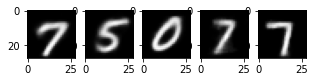

epoch 27 reconstruction loss: 64.453


100%|██████████| 1875/1875 [00:26<00:00, 70.47it/s]


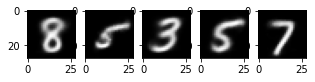

epoch 28 reconstruction loss: 64.264


100%|██████████| 1875/1875 [00:26<00:00, 70.66it/s]


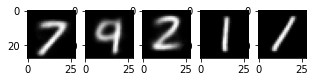

epoch 29 reconstruction loss: 64.121


100%|██████████| 1875/1875 [00:26<00:00, 70.62it/s]


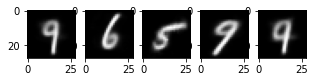

epoch 30 reconstruction loss: 63.973


In [21]:
################################################################################
# train model ##################################################################

# train single epoch
def train_autoencoder_single_epoch(model, dataloader):
    model.train().cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    epoch_loss = 0
    # train model
    for imgs, labels in tqdm(dataloader):
        optimizer.zero_grad()
        imgs = imgs.cuda()
        imgs_regen, z = model(imgs)
        loss = criterion(imgs_regen.view(-1, 784), imgs.view(-1, 784))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # plot regenerated imgs
    fig = plt.figure(figsize=(5, 30))
    for idx in range(5):
        img = imgs_regen[idx].cpu().squeeze().detach().numpy()
        ax = fig.add_subplot(1, 5, idx + 1)
        ax.imshow(img, cmap=cm.gray)
    plt.show()
    return epoch_loss

# train model
def train_autoencoder(model, dataloader, n_epoch=30):
    loss_list = []
    model
    for idx_epoch in range(n_epoch):
        epoch_loss = train_autoencoder_single_epoch(model, dataloader)
        print('epoch', idx_epoch + 1,'reconstruction loss: {:3.3f}'.format(epoch_loss))
    return model

################################################################################


################################################################################
# excecute #####################################################################
model = Autoencoder()
trained_ae = train_autoencoder(model, train_loader, n_epoch=30)
################################################################################

## **Plot Latenet Vector**
Latenet vector (z) plotted for test dataset

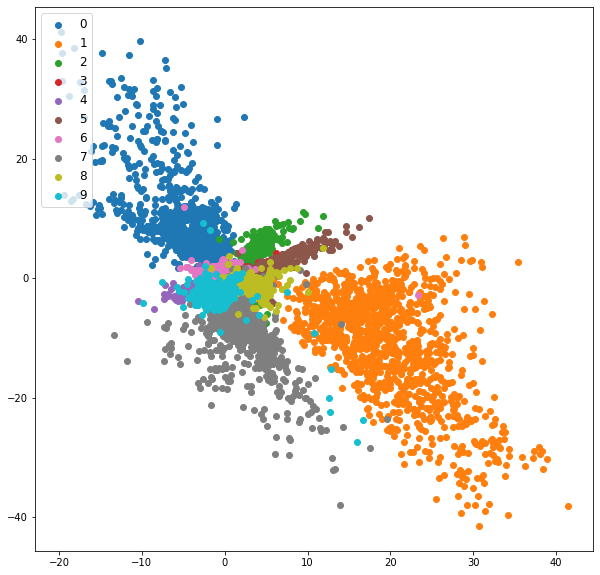

In [22]:
################################################################################
# plot fxns ####################################################################

def plot_scatter(model, loader):
    # get z sampling
    model.cpu()
    z_sampled = []
    label_sampled = []
    for imgs, labels in loader:
        _, z = model(imgs)
        z_sampled.append(z) # z[b 2]
        label_sampled.append(labels)
    del imgs
    z_to_plot = torch.cat(z_sampled, dim=0).cpu() # z[n 2]
    label_to_plot = torch.cat(label_sampled, dim=0)
    z_to_plot = z_to_plot[:,:]
    label_to_plot = label_to_plot[:]
    # plot
    x_data = z_to_plot[:,0].squeeze().detach().numpy()
    y_data = z_to_plot[:,1].squeeze().detach().numpy()
    label_data = label_to_plot[:].squeeze().detach().numpy()
    plot_group = [[[],[]] for _ in range(10)]
    for idx in range(len(x_data)):
        label = label_data[idx]
        plot_group[label][0].append(x_data[idx])
        plot_group[label][1].append(y_data[idx])
    plt.figure(figsize=(10,10))
    for number, group in enumerate(plot_group):
        x, y = group
        plt.scatter(x, y, label = str(number))
    plt.legend(fontsize=12, loc='upper left')
    plt.show()
    return None
    
################################################################################


################################################################################
# plot z vector#################################################################
plot_scatter(trained_ae, test_loader)
################################################################################